In [1]:
import pymc3 as pm
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from pynba import possessions_from_file, team_id_to_abb, plot_ratings, use_blackontrans_style


league = "nba"
year = 2019
season_type = "Regular Season"

In [2]:
possessions = possessions_from_file(league, year, season_type)

In [18]:
possessions["points_scored_corrected"] = possessions["points_scored"].map(lambda val: min(val, 4))
grouped = possessions.groupby(by=["off_team_id", "def_team_id", "home_team_id"], as_index=False)
matchups = grouped.agg(
    {
        "league": "first",
        "year": "first",
        "season_type": "first",
        "date": "first",
        "points_scored_corrected": "sum",
        "possession_num": "count",
    }
)
results = np.array([
    [(subgroup["points_scored_corrected"] == ind).sum() for ind in range(5)]
    for _, subgroup in grouped
])

In [4]:
n_teams = matchups["off_team_id"].unique().shape[0]
team_id_to_team_ind = {
    team_id: team_ind
    for team_ind, team_id in enumerate(matchups["off_team_id"].unique())
}
team_id_to_team_abb = team_id_to_abb(league, year)
team_abb_to_team_id = {
    team_abb: team_id
    for team_id, team_abb in team_id_to_team_abb.items()
}
team_ind_to_team_abb = {
    team_ind: team_id_to_team_abb[team_id]
    for team_id, team_ind in team_id_to_team_ind.items()
}
mu = results.sum(0) / results.sum()
off_index = (
    matchups["off_team_id"].map(team_id_to_team_ind).to_numpy()
)
def_index = (
    matchups["def_team_id"].map(team_id_to_team_ind).to_numpy()
)
home_index = (
    (matchups["off_team_id"] != matchups["home_team_id"])
    .to_numpy()
    .astype(int)
)

with pm.Model() as model:
    alpha0_off = pm.Gamma("alpha0_off", mu=1000, sigma=300)
    alpha0_def = pm.Gamma("alpha0_def", mu=2000, sigma=500)
    alpha_off = mu * alpha0_off
    alpha_def = mu * alpha0_def
    alpha_home = (mu + np.array([-0.006, 0, 0.004, 0.002, 0])) * 100000
    teams_off = pm.Dirichlet("team_off", alpha_off, shape=(n_teams, 5))
    teams_def = pm.Dirichlet("team_def", alpha_def, shape=(n_teams, 5))
    hc_off = pm.Dirichlet("hc_off", alpha_home)
    hc_def = 2 * mu - hc_off
    offense = teams_off[off_index]
    defense = teams_def[def_index]
    home_court = pm.math.stack([hc_off, hc_def])[home_index]
    mu0 = np.tile((mu / (1 - mu)), (off_index.shape[0], 1))
    p0 = offense / (1 - offense) * defense / (1 - defense) * home_court / (1 - home_court) / mu0 ** 2
    p = p0 / (p0 + 1)
    pm.Multinomial("game_result", n=matchups["possession_num"].to_numpy().reshape(-1, 1), p=p, observed=results)

In [5]:
with model:
    trace = pm.sample(
        draws=10000,
        init="adapt_diag",
        chains=4,
        random_seed=42,
        return_inferencedata=False,
    )

2021-07-10 21:21:39 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:sample @ 495 | INFO | Auto-assigning NUTS sampler...
2021-07-10 21:21:39 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:init_nuts @ 2081 | INFO | Initializing NUTS using adapt_diag...
2021-07-10 21:23:15 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:sample @ 556 | INFO | Multiprocess sampling (4 chains in 4 jobs)
2021-07-10 21:23:15 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:_print_step_hierarchy @ 232 | INFO | NUTS: [hc_off, team_def, team_off, alpha0_def, alpha0_off]


2021-07-10 22:07:34 UTC | /home/jupyter/venv/lib/python3.8/site-packages/pymc3/sampling.py:sample @ 628 | INFO | Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 2658 seconds.


In [6]:
off_probs = trace["team_off"].mean(0)
off_ratings = ((off_probs - mu).dot(np.arange(5).reshape(-1, 1)) * 100).reshape(-1)
def_probs = trace["team_def"].mean(0)
def_ratings = ((mu - def_probs).dot(np.arange(5).reshape(-1, 1)) * 100).reshape(-1)

In [16]:
results_df = pd.DataFrame({
    "team": [team_ind_to_team_abb[ind] for ind in range(n_teams)],
    "net_scoring_above_average": off_ratings + def_ratings,
    "off_scoring_above_average": off_ratings,
    "def_scoring_above_average": def_ratings,
    "league": league,
    "year": year,
    "season_type": season_type,
})

results_df.sort_values("net_scoring_above_average", ascending=False)

,team,net_scoring_above_average,off_scoring_above_average,def_scoring_above_average,league,year,season_type
12,MIL,6.514540,3.146588,3.367953,nba,2019,Regular Season
7,GSW,5.594340,4.637548,0.956792,nba,2019,Regular Season
24,TOR,4.441016,2.327319,2.113697,nba,2019,Regular Season
8,HOU,4.162117,4.397545,-0.235429,nba,2019,Regular Season
25,UTA,3.990294,0.373729,3.616566,nba,2019,Regular Season
20,POR,3.693816,3.550877,0.142939,nba,2019,Regular Season
6,DEN,3.569358,2.111179,1.458179,nba,2019,Regular Season
1,BOS,3.028115,1.238901,1.789215,nba,2019,Regular Season
23,OKC,2.663322,-0.084723,2.748045,nba,2019,Regular Season
17,IND,2.035635,-0.513273,2.548908,nba,2019,Regular Season


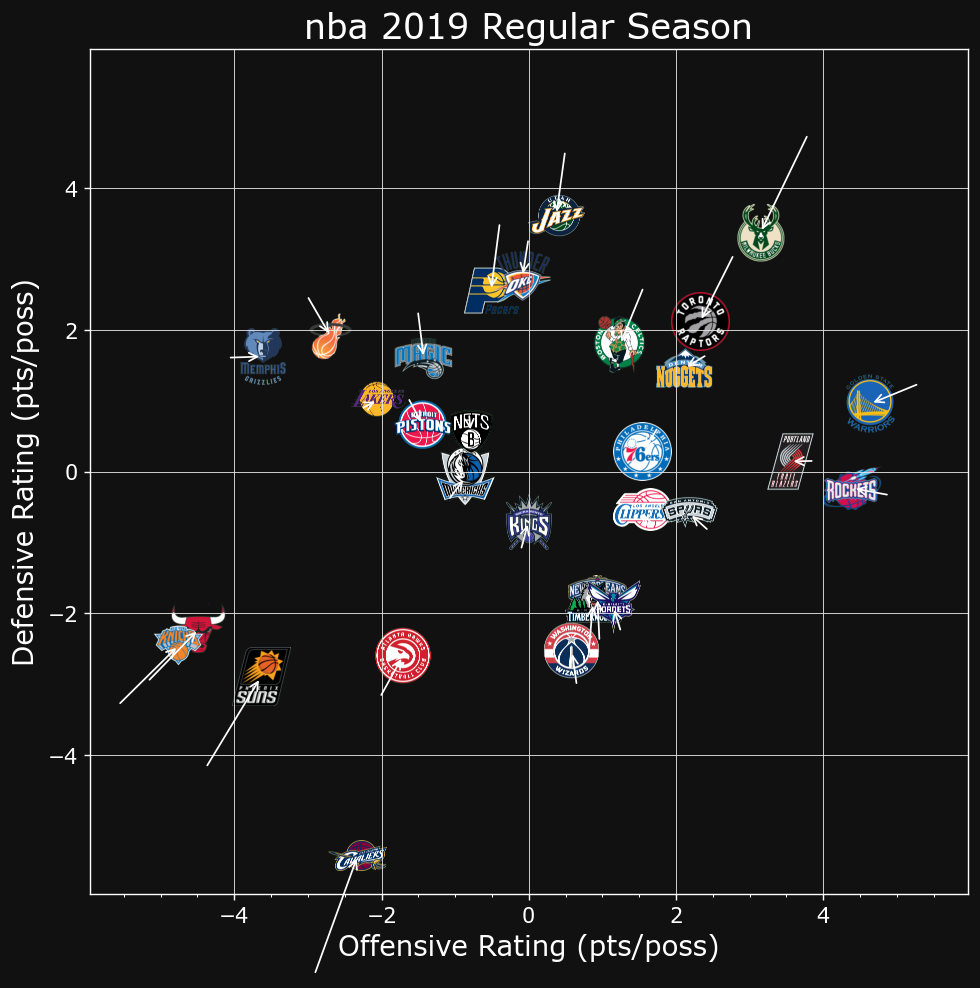

In [17]:
use_blackontrans_style()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
points_mu = possessions["points_scored_corrected"].sum() / possessions.shape[0] * 100
for team, off_aa, def_aa in zip(results_df["team"], results_df["off_scoring_above_average"], results_df["def_scoring_above_average"]):
    team_id = team_abb_to_team_id[team]
    filt = matchups["off_team_id"] == team_id
    raw_off = matchups.loc[filt, "points_scored_corrected"].sum() / matchups.loc[filt, "possession_num"].sum() * 100 - points_mu
    filt = matchups["def_team_id"] == team_id
    raw_def = points_mu - matchups.loc[filt, "points_scored_corrected"].sum() / matchups.loc[filt, "possession_num"].sum() * 100
    ax.annotate("", xy=(off_aa, def_aa), xytext=(raw_off, raw_def), arrowprops={"arrowstyle": "->", "color": "white"})
plot_ratings(results_df, ax)
